In [2]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500) 

In [4]:
df = pd.read_csv('diabetes.csv')

In [5]:
def analyze_data(dataframe):
    print('########## HEAD #################')
    print(dataframe.head())
    print('############## INFO #############')
    print(dataframe.info())
    print('############ DESCRIBE ###########')
    print(dataframe.describe().T)
    print('########### SHAPE ###############')
    print(dataframe.shape)
    print('########### ISNA ###############')
    print(dataframe.isna().sum())
    print('############ TYPES ##############')
    print(dataframe.dtypes)
    print("########### QUANTILES ###########")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)  

In [6]:
analyze_data(df)

########## HEAD #################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1                     0.167   21        0
4            0      137             40             35      168  43.1                     2.288   33        1
############## INFO #############
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Gluc

In [7]:
def grab_col_names(dataframe, cat_th = 10, car_th = 20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != 'O'
                        and dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == 'O' and
                        dataframe[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [9]:
def outliers(dataframe, col_name, q1=0.05, q3=0.95):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    interq = quantile3 - quantile1
    
    down = quantile1 - 1.5 * interq
    up = quantile3 + 1.5 * interq
    
    return down, up

In [10]:
for col in num_cols:
    print(outliers(df, col))

(-15.0, 25.0)
(-74.0, 334.0)
(-38.249999999999986, 166.95)
(-66.0, 110.0)
(-439.5, 732.5)
(-12.09249999999999, 78.2875)
(-1.3483999999999996, 2.621599999999999)
(-34.5, 113.5)


In [11]:
def check_outliers(dataframe, col_name):
    down, up = outliers(dataframe, col_name)
    if dataframe[(dataframe[col_name] < down) | (dataframe[col_name] > up)].any(None):
        return True
    else:
        return False

In [12]:
for col in num_cols:
    print(col, check_outliers(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


C:\Users\s7522\AppData\Local\Temp\ipykernel_17796\3667971048.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe[(dataframe[col_name] < down) | (dataframe[col_name] > up)].any(None):
C:\Users\s7522\AppData\Local\Temp\ipykernel_17796\3667971048.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe[(dataframe[col_name] < down) | (dataframe[col_name] > up)].any(None):
C:\Users\s7522\AppData\Local\Temp\ipykernel_17796\3667971048.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe[(dataframe[col_name] < down) | (dataframe[col_name] > up)].any(None):
C:\Users\s7522\AppData\Local\Temp\ipykernel_17796\3667971048.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe[(dataframe

In [13]:
def replace_outliers(dataframe,col_name):
    down, up = outliers(dataframe,col_name)
    if dataframe.loc[(dataframe[col_name] > up) | (dataframe[col_name] < down)].any(None):
        dataframe.loc[(dataframe[col_name] < down) , col_name] = down
        dataframe.loc[(dataframe[col_name] > up) , col_name] = up
        return dataframe

In [14]:
for col in num_cols:
    replace_outliers(df, col)

C:\Users\s7522\AppData\Local\Temp\ipykernel_17796\3918181790.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe.loc[(dataframe[col_name] > up) | (dataframe[col_name] < down)].any(None):
C:\Users\s7522\AppData\Local\Temp\ipykernel_17796\3918181790.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe.loc[(dataframe[col_name] > up) | (dataframe[col_name] < down)].any(None):
C:\Users\s7522\AppData\Local\Temp\ipykernel_17796\3918181790.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe.loc[(dataframe[col_name] > up) | (dataframe[col_name] < down)].any(None):
C:\Users\s7522\AppData\Local\Temp\ipykernel_17796\3918181790.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if datafram

In [15]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name : dataframe[col_name].value_counts(),
                        'Ratio' : dataframe[col_name].value_counts()/ len(dataframe)}))
    print('################################')
    if plot :
        sns.countplot( x=dataframe[col_name], data=dataframe)
        plt.show()

   Outcome     Ratio
0      500  0.651042
1      268  0.348958
################################


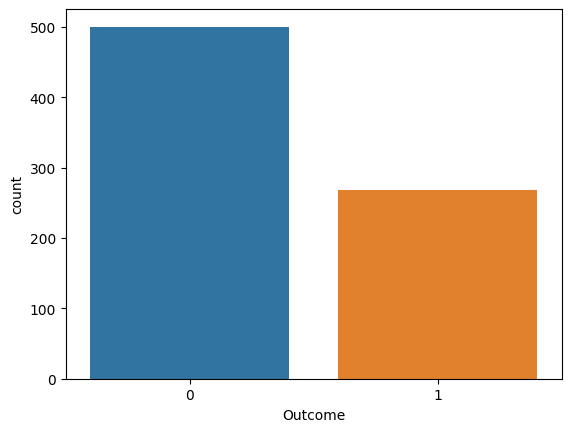

In [16]:
for col in cat_cols:
    cat_summary(df, col, plot = True)

In [17]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


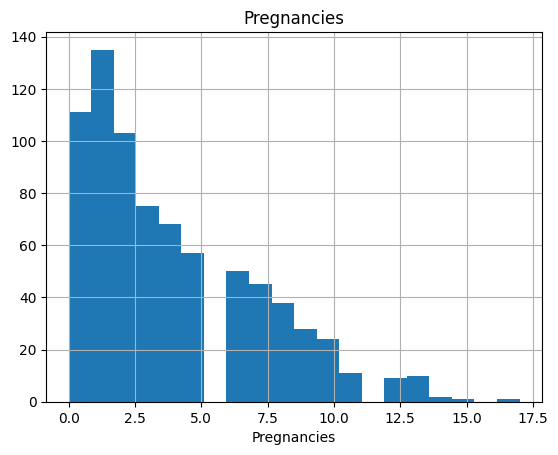

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


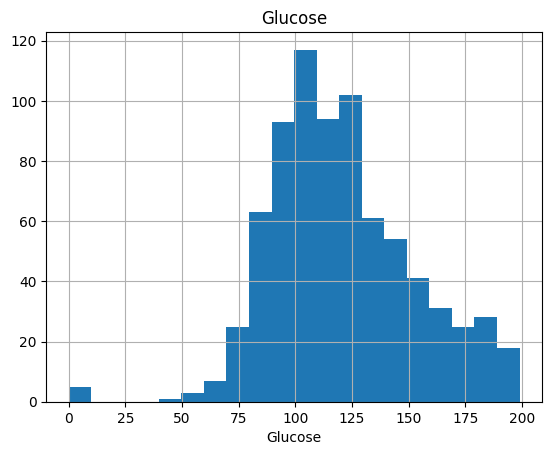

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


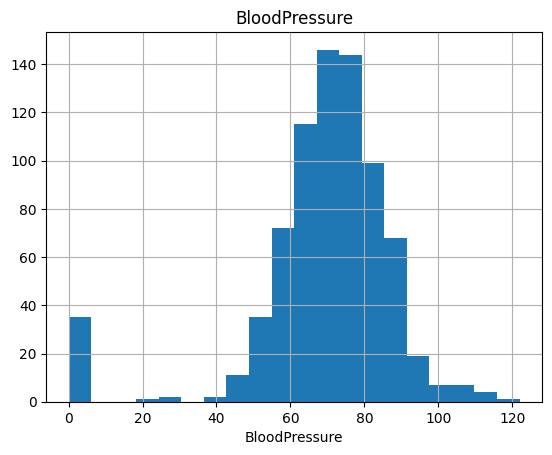

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


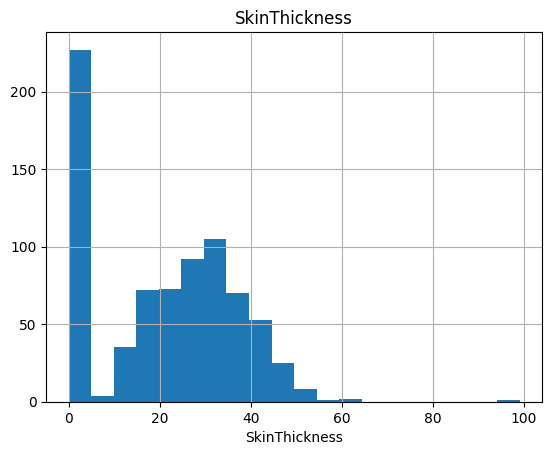

count    768.000000
mean      79.636719
std      114.242903
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      732.500000
Name: Insulin, dtype: float64


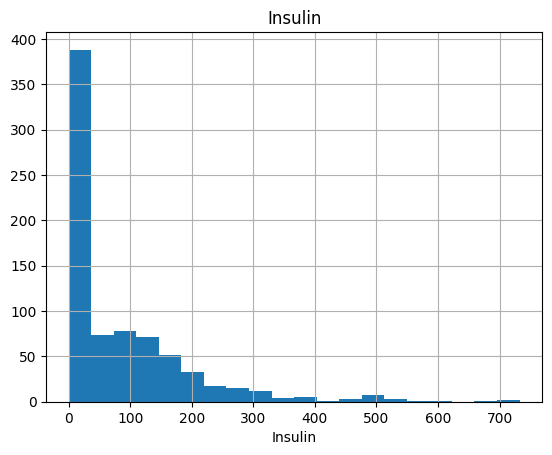

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


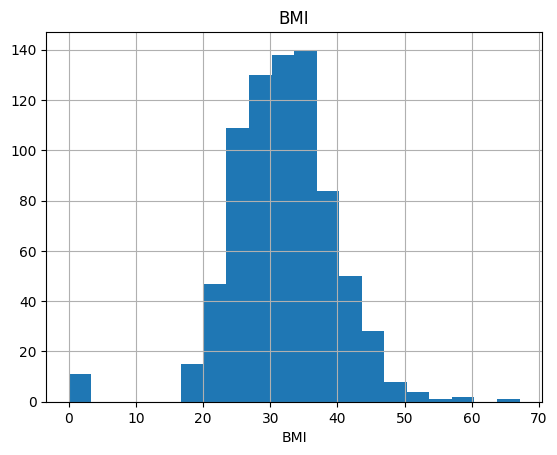

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


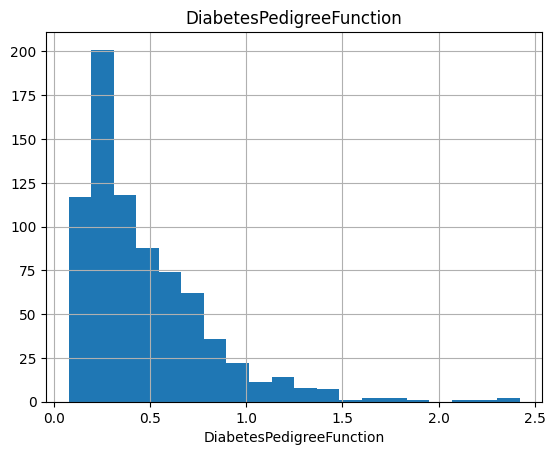

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


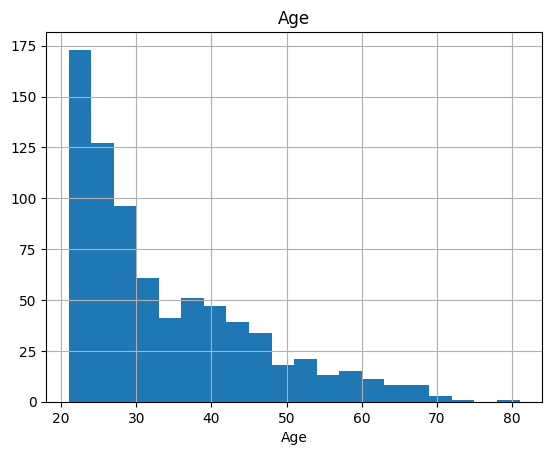

In [18]:
for col in num_cols:
    num_summary(df, col, plot = True)

In [19]:
def target_summary_with_num(dataframe, target, num_col):
    print(dataframe.groupby(target)[num_col].agg('mean'))

In [20]:
for col in num_cols:
    target_summary_with_num(df, 'Outcome', col)

Outcome
0    3.298000
1    4.865672
Name: Pregnancies, dtype: float64
Outcome
0    109.980000
1    141.257463
Name: Glucose, dtype: float64
Outcome
0    68.184000
1    70.824627
Name: BloodPressure, dtype: float64
Outcome
0    19.664000
1    22.164179
Name: SkinThickness, dtype: float64
Outcome
0    68.769000
1    99.912313
Name: Insulin, dtype: float64
Outcome
0    30.304200
1    35.142537
Name: BMI, dtype: float64
Outcome
0    0.429734
1    0.550500
Name: DiabetesPedigreeFunction, dtype: float64
Outcome
0    31.190000
1    37.067164
Name: Age, dtype: float64


In [21]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isna().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum()/dataframe.shape[0])
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)

df.isnull().sum()

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [22]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot = True, linewidths=0.5, annot_kws={'size' : 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

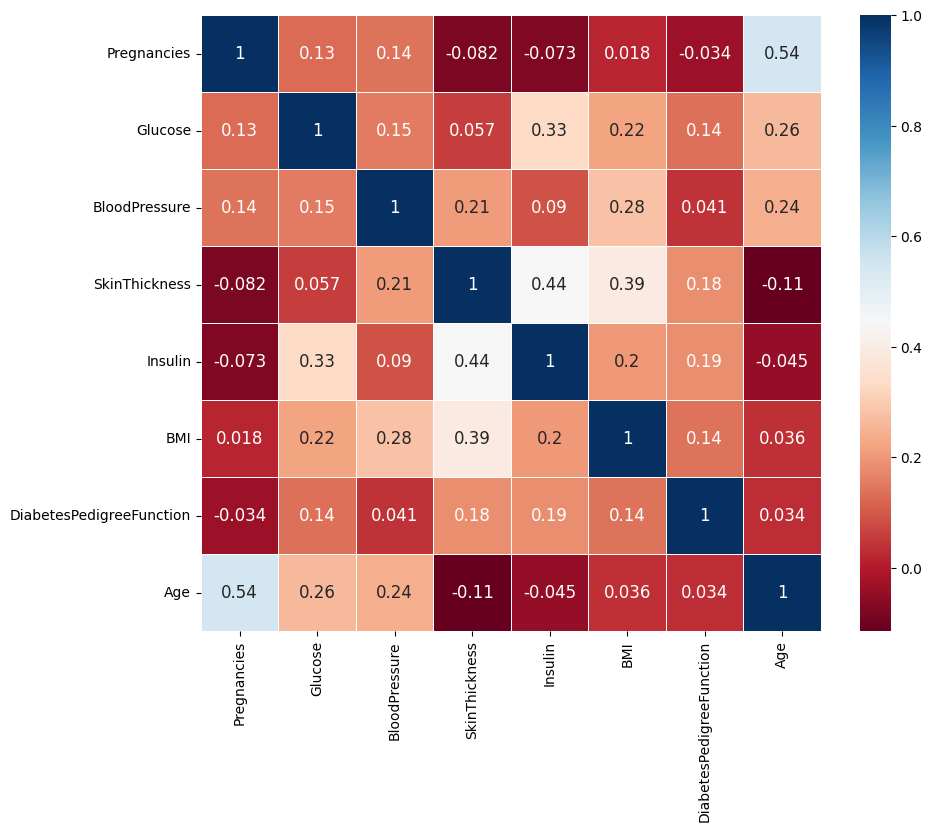

In [23]:
correlation_matrix(df, num_cols)

In [24]:
def one_hot_encoder(dataframe, categorical_cols, drop_first = False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [25]:
df.columns = [col.upper() for col in df.columns]

In [26]:
df['NEW_GLUCOSE_CAT'] = pd.cut(x=df['GLUCOSE'], bins=[-1, 139, 200], labels=['normal', 'prediabetes'])

df.loc[(df['AGE'] >= 35), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 35) & (df['AGE'] < 55), 'NEW_AGE_CAT'] = 'middleage'
df.loc[(df['AGE'] > 55) , 'NEW_AGE_CAT'] = 'old'

df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins = [-1, 18.5, 24.9, 29.9, 100],
                             labels = ['underweight', 'healthy', 'overweight', 'obese'])

df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels = ['normal','hs1','hs2'])

In [28]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th = 20)

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 4


In [29]:
for col in cat_cols:
    cat_summary(df, col)

           NEW_AGE_CAT     Ratio
middleage          226  0.294271
old                 50  0.065104
young                4  0.005208
################################
   OUTCOME     Ratio
0      500  0.651042
1      268  0.348958
################################
             NEW_GLUCOSE_CAT    Ratio
normal                   571  0.74349
prediabetes              197  0.25651
################################
             NEW_BMI_RANGE     Ratio
obese                  472  0.614583
overweight             179  0.233073
healthy                102  0.132812
underweight             15  0.019531
################################
        NEW_BLOODPRESSURE     Ratio
normal                563  0.733073
hs1                   145  0.188802
hs2                    60  0.078125
################################


In [31]:
cat_cols = [col for col in cat_cols if'OUTCOME' not in col]

In [32]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [33]:
df.columns = [col.upper() for col in df.columns]

In [35]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

Observations: 768
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 9


In [36]:
cat_cols = [col for col in cat_cols if col not in 'OUTCOME']

In [38]:
for col in num_cols :
    print(col, check_outliers(df, col))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN False
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


C:\Users\s7522\AppData\Local\Temp\ipykernel_17796\3667971048.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe[(dataframe[col_name] < down) | (dataframe[col_name] > up)].any(None):
C:\Users\s7522\AppData\Local\Temp\ipykernel_17796\3667971048.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe[(dataframe[col_name] < down) | (dataframe[col_name] > up)].any(None):
C:\Users\s7522\AppData\Local\Temp\ipykernel_17796\3667971048.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe[(dataframe[col_name] < down) | (dataframe[col_name] > up)].any(None):
C:\Users\s7522\AppData\Local\Temp\ipykernel_17796\3667971048.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe[(dataframe

In [41]:
X_scaled = StandardScaler().fit_transform(df[num_cols])

In [43]:
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

In [44]:
y = df['OUTCOME']

In [45]:
X = df.drop(['OUTCOME'], axis=1)

In [47]:
X.shape

(768, 16)

In [48]:
#Base Models

In [60]:
def base_models(X, y, scoring = 'roc_auc'):
    print('Base Models.....')
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ('SVC', SVC()),
                   ('CART', DecisionTreeClassifier()),
                   ('RF', RandomForestClassifier()),
                   ('AdaBoost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier())]
                  # ('CatBoost', CatBoostClassifier(verbose = False))]
    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring = scoring)
        print(f'{scoring}: {round(cv_results["test_score"].mean(), 4)} ({name})')
        

In [61]:
base_models(X,y)

Base Models.....
roc_auc: 0.8422 (LR)


c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


roc_auc: 0.779 (KNN)
roc_auc: 0.8341 (SVC)
roc_auc: 0.6559 (CART)
roc_auc: 0.8207 (RF)
roc_auc: 0.8178 (AdaBoost)
roc_auc: 0.8262 (GBM)


c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


roc_auc: 0.7983 (XGBoost)
[LightGBM] [Info] Number of positive: 178, number of negative: 334
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347656 -> initscore=-0.629357
[LightGBM] [Info] Start training from score -0.629357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [62]:
base_models(X,y,scoring='f1')

Base Models.....
f1: 0.6257 (LR)
f1: 0.6186 (KNN)


c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


f1: 0.617 (SVC)
f1: 0.5303 (CART)
f1: 0.6346 (RF)
f1: 0.632 (AdaBoost)
f1: 0.6371 (GBM)


c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


f1: 0.6315 (XGBoost)
[LightGBM] [Info] Number of positive: 178, number of negative: 334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347656 -> initscore=-0.629357
[LightGBM] [Info] Start training from score -0.629357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [63]:
#Automated Hyperparameter Optimization

In [71]:
knn_params = {'n_neighbors' : range(2,50)}

cart_params = {'max_depth' : range(2,50),
               'min_samples_split' : range(2,30)}

rf_params = {'max_depth' : [8, 15, None],
             'max_features' : [5, 7, 'auto'],
             'min_samples_split' :[15, 20],
             'n_estimators' :[200, 300]}

xgboost_params = {'learning_rate' : [0.1, 0.01],
                  'max_depth' : [5, 8],
                  'n_estimators' : [100, 200],
                  'colsample_bytree' : [0.5, 1]}

lightgbm_params = {'learning_rate' : [0.1, 0.01],
                   'n_estimators' : [300,500],
                   'colsample_bytree' : [0.7, 1]}

classifiers = [    ('KNN', KNeighborsClassifier(), knn_params),
                   ('CART', DecisionTreeClassifier(), cart_params),
                   ('RF', RandomForestClassifier(), rf_params),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
                   ('LightGBM', LGBMClassifier(), lightgbm_params),]



In [72]:
def hyperparameter_optimization(X, y, cv=3, scoring = 'roc_auc'):
    print('Hyperparameter Optimization.....')
    best_models = {}
    for name, classifier, params in classifiers:
        print(f'############### {name} ############')
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before) : {round(cv_results['test_score'].mean(), 4)}")
        
        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs= -1, verbose=False).fit(X,y)
        final_model = classifier.set_params(**gs_best.best_params_)
        
        cv_results = cross_validate(final_model, X, y, cv=cv,scoring=scoring)
        print(f"{scoring} (After) : {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params : {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models    

In [79]:
best_models = hyperparameter_optimization(X,y)

Hyperparameter Optimization.....
############### KNN ############
roc_auc (Before) : 0.8071
roc_auc (After) : 0.8071
KNN best params : {'n_neighbors': 10}

############### CART ############
roc_auc (Before) : 0.7975
roc_auc (After) : 0.7996
CART best params : {'max_depth': 6, 'min_samples_split': 25}

############### RF ############
roc_auc (Before) : 0.8306
roc_auc (After) : 0.8333
RF best params : {'max_depth': 8, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 200}

############### XGBoost ############


c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


roc_auc (Before) : 0.8249


c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\s7522\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encode

roc_auc (After) : 0.8249
XGBoost best params : {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 200}

############### LightGBM ############
[LightGBM] [Info] Number of positive: 178, number of negative: 334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347656 -> initscore=-0.629357
[LightGBM] [Info] Start training from score -0.629357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [86]:
best_models

{'KNN': KNeighborsClassifier(n_neighbors=10),
 'CART': DecisionTreeClassifier(max_depth=6, min_samples_split=25),
 'RF': RandomForestClassifier(max_depth=8, max_features=7, min_samples_split=15,
                        n_estimators=200),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.5, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.01, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_stat

In [74]:
#Stacking & Ensemble Learning

In [92]:
def voting_classifier(best_models, X, y):
    print('Voting Classifier...')
    voting_clf = VotingClassifier(estimators = [('KNN', best_models["KNN"]), 
                                                ('RF',best_models["RF"]),
                                                ('LightGBM', best_models["LightGBM"])],
                                  voting = 'soft').fit(X,y)
    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring = ['accuracy', 'f1', 'roc_auc'])
    print(f"Accuracy : {cv_results['test_accuracy'].mean()}")
    print(f"F1 Score : {cv_results['test_f1'].mean()}")
    print(f"Roc_Auc : {cv_results['test_roc_auc'].mean()}")
    return voting_clf

In [97]:
voting_cls = voting_classifier(best_models, X, y)

Voting Classifier...
[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [98]:
#Prediction

In [99]:
random_user = X.sample(1, random_state=45)

In [100]:
voting_cls.predict(random_user)

array([1], dtype=int64)

In [104]:
joblib.dump(voting_cls, 'voting_clf2.pkl')

['voting_clf2.pkl']

In [1]:
#Model Deployment